In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
import os
print(os.getcwd())

c:\Users\thsat\opencampus25\project


In [ ]:
SqueezeNet_Dataset_TransferLearning/
├── NoActivity/
│   ├── Image0.png
│   ├── ...
├── YesActivity/
│   ├── Image0.png
│   ├── ...


In [13]:
from PIL import Image

image_path = r'C:\Users\thsat\opencampus25\project\SqueezeNet_Dataset_TransferLearning\NoActivity\Image0.png'

with Image.open(image_path) as img:
    print("Image size:", img.size)  # (width, height)
    print("Image mode:", img.mode)  # e.g., 'RGB', 'RGBA', 'L'


Image size: (224, 224)
Image mode: RGBA


In [12]:
from PIL import Image
import numpy as np

image_path = r'C:\Users\thsat\opencampus25\project\SqueezeNet_Dataset_TransferLearning\NoActivity\Image0.png'

with Image.open(image_path) as img:
    # Convert from RGBA to RGB (drops alpha)
    img_rgb = img.convert('RGB')
    image_array = np.array(img_rgb)

print("New image shape:", image_array.shape)  # Should be (224, 224, 3)

New image shape: (224, 224, 3)


In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

dataset_dir = r'C:\Users\thsat\opencampus25\project\SqueezeNet_Dataset_TransferLearning'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load dataset and split
train_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Optimize dataset pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.


# plot classes

Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.
Class names: ['NoActivity', 'YesActivity']


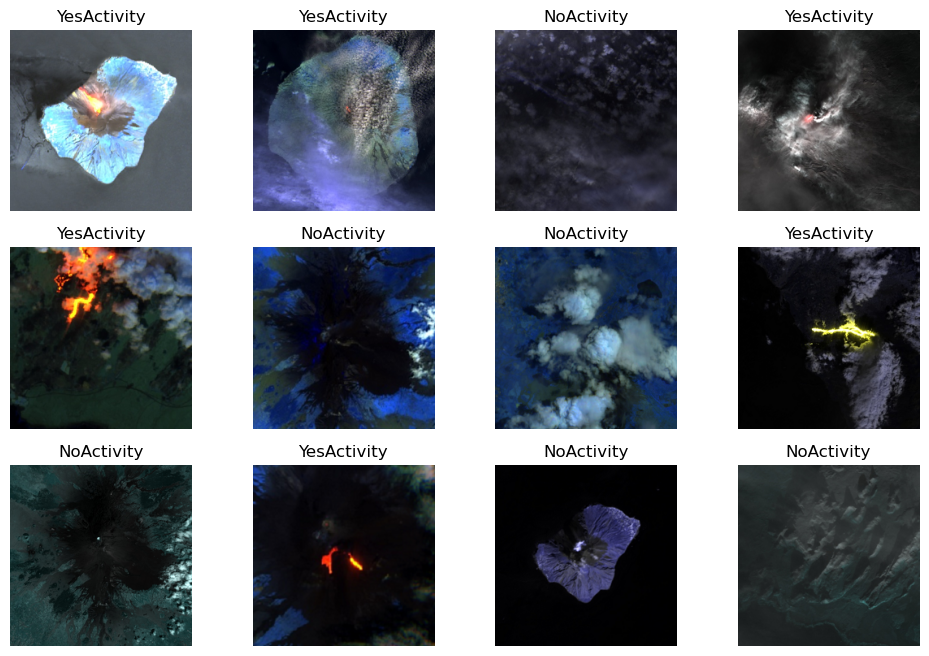

In [19]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Save class names before prefetch
class_names = train_ds_raw.class_names
print("Class names:", class_names)

# Prefetch separately
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(AUTOTUNE)
val_ds = val_ds_raw.prefetch(AUTOTUNE)


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = int(labels[i])
        plt.title(class_names[label])
        plt.axis("off")


# model

In [20]:
# Load base MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze for transfer learning

# Build your classifier
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# train the model

In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
5/5 [==============================] - 8s 806ms/step - loss: 0.7895 - accuracy: 0.5312 - val_loss: 0.8696 - val_accuracy: 0.2750
Epoch 2/10
5/5 [==============================] - 3s 516ms/step - loss: 0.9398 - accuracy: 0.3750 - val_loss: 0.8574 - val_accuracy: 0.3000
Epoch 3/10
5/5 [==============================] - 3s 521ms/step - loss: 0.8703 - accuracy: 0.4375 - val_loss: 0.8462 - val_accuracy: 0.3250
Epoch 4/10
5/5 [==============================] - 2s 505ms/step - loss: 0.8621 - accuracy: 0.4250 - val_loss: 0.8316 - val_accuracy: 0.3250
Epoch 5/10
5/5 [==============================] - 2s 508ms/step - loss: 0.7719 - accuracy: 0.4875 - val_loss: 0.8186 - val_accuracy: 0.3500
Epoch 6/10
5/5 [==============================] - 2s 508ms/step - loss: 0.8493 - accuracy: 0.4375 - val_loss: 0.8081 - val_accuracy: 0.4000
Epoch 7/10
5/5 [==============================] - 2s 511ms/step - loss: 0.7874 - accuracy: 0.5250 - val_loss: 0.8008 - val_accuracy: 0.4000
Epoch 8/10
5/5 [====

# evaluate

In [ ]:
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
5/5 [==============================] - 19s 3s/step - loss: 0.7277 - accuracy: 0.5375 - val_loss: 0.7240 - val_accuracy: 0.5250
Epoch 2/5
5/5 [==============================] - 11s 2s/step - loss: 0.6397 - accuracy: 0.6562 - val_loss: 0.7222 - val_accuracy: 0.5250
Epoch 3/5
5/5 [==============================] - 11s 2s/step - loss: 0.5836 - accuracy: 0.7250 - val_loss: 0.7301 - val_accuracy: 0.5250
Epoch 4/5
5/5 [==============================] - 11s 2s/step - loss: 0.5032 - accuracy: 0.7625 - val_loss: 0.7139 - val_accuracy: 0.5000
Epoch 5/5
5/5 [==============================] - 11s 2s/step - loss: 0.4936 - accuracy: 0.8125 - val_loss: 0.6771 - val_accuracy: 0.5500


1/1 [==============================] - 0s 454ms/step


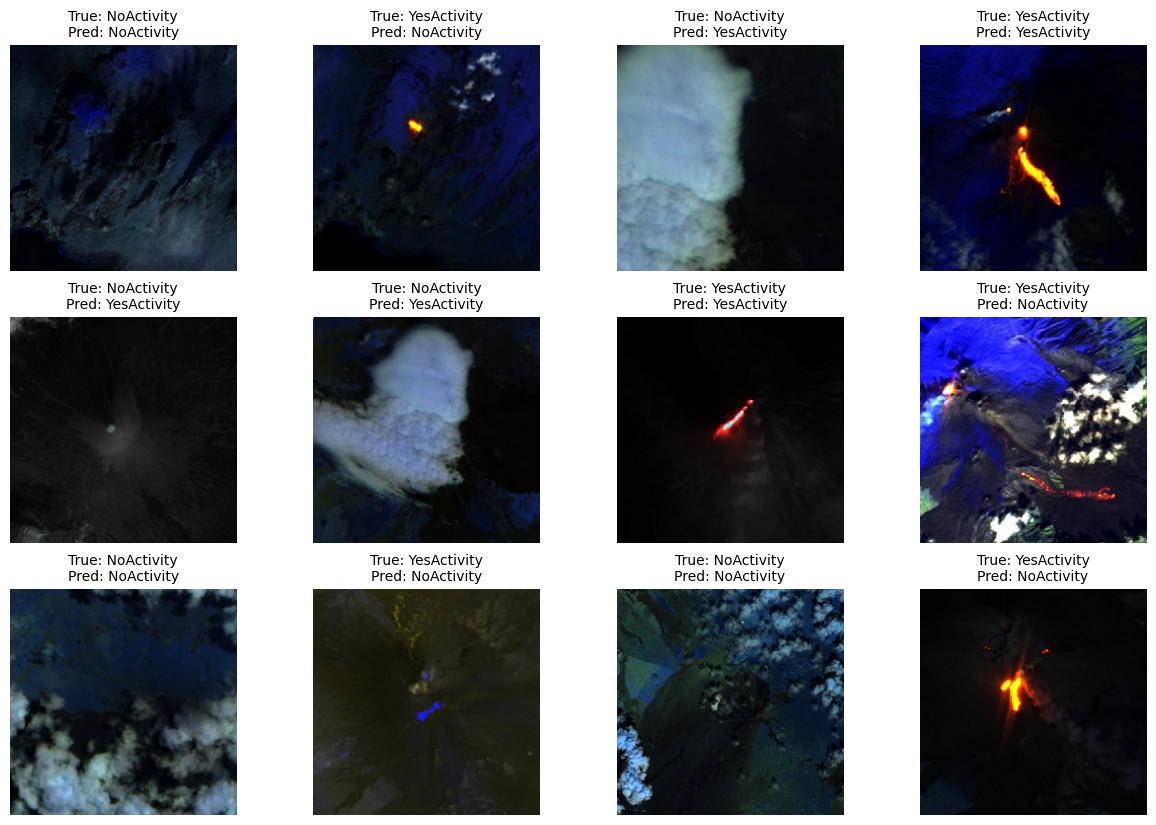

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    predicted_labels = (predictions.flatten() >= 0.5).astype(int)  # Threshold at 0.5

    plt.figure(figsize=(15, 10))
    for i in range(min(12, len(images))):  # Show up to 12 images
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = int(labels[i].numpy())
        pred_label = predicted_labels[i]
        title = f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}"
        plt.title(title, fontsize=10)
        plt.axis("off")
    break
